# Support Vector Machines from scratch

In [8]:
import os
import torch
import cvxopt
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [9]:
X, y = make_blobs(n_samples=200, n_features=2, centers=2)

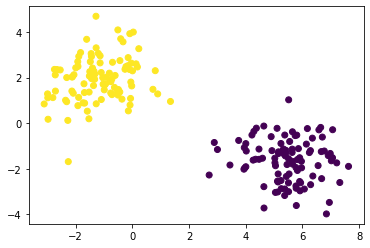

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=y)

$$
    \large
    \max_{\boldsymbol{\sigma}; \boldsymbol{\sigma} \geq 0}  \sum_{i=1}^{N}\sigma_i - \frac{1}{2} \sum_{i=1}^{N}\sum_{j=1}^{N} \sigma_i \sigma_j y_i y_j \boldsymbol{x}_i^\top \boldsymbol{x}_j \\
    \large
    \min_{\boldsymbol{\sigma}; \boldsymbol{\sigma} \geq 0}  \frac{1}{2} \sum_{i=1}^{N}\sum_{j=1}^{N} \sigma_i \sigma_j y_i y_j \boldsymbol{x}_i^\top \boldsymbol{x}_j -  \sum_{i=1}^{N}\sigma_i  
$$


$$
\large
    P_{ij} = y_i y_j \boldsymbol{x}_i^\top\boldsymbol{x}_j
$$

$$
    \large
    \boldsymbol{w} = \sum_{i=1}^{N} y_i \sigma_i \boldsymbol{x}_i
$$

$$
    \large
    b = y_s - \sum_{m \in S} \sigma_m y_m \boldsymbol{x}_m^\top \boldsymbol{x}_s \\
    \text{where} \; S \; \text{is the set of support vectors such as} \; \sigma_i > 0
$$